# QAOA 
Reference: https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut

In [1]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import os
from datetime import datetime
from pennylane import qaoa

## Graph generating function

In [2]:
def generate_random_graph(n_nodes=8, p=0.5, seed=None):
    G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = float(np.random.uniform(1, 10))
    G = nx.convert_node_labels_to_integers(G)
    return G

## Algorithm function

In [3]:
def maxcut_qaoa(G, p_layers=1, optimizer_steps=50, seed=None):
    np.random.seed(seed)
    n = G.number_of_nodes()
    dev = qml.device("default.qubit", wires=n)

    cost_h, mixer_h = qaoa.maxcut(G)

    @qml.qnode(dev)
    def circuit(params):
        for i in range(p_layers):
            qml.qaoa.cost_layer(params[i][0], cost_h)
            qml.qaoa.mixer_layer(params[i][1], mixer_h)
        return qml.expval(cost_h)

    params = 0.01 * np.random.randn(p_layers, 2)
    params = qml.numpy.array(params, requires_grad=True)
    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    for step in range(optimizer_steps):
        params = opt.step(lambda v: circuit(v), params)  # Minimize expectation value

    cut_value = -circuit(params)  # Negate to get the Max-Cut value
    return None, float(cut_value)

## Experiment function

In [4]:
def run_qaoa_experiment_time_budget(sizes, edge_prob=0.5, time_per_size=420, p_layers=1, optimizer_steps=50):
    all_cut_values = []

    for n_nodes in sizes:
        cut_values = []
        start_time = time.time()
        g_idx = 0

        while time.time() - start_time < time_per_size:
            G = generate_random_graph(n_nodes=n_nodes, p=edge_prob, seed=g_idx)
            if G.number_of_edges() == 0:
                # Skip graphs with no edges
                g_idx += 1
                continue
            _, value = maxcut_qaoa(G, p_layers=p_layers, optimizer_steps=optimizer_steps, seed=g_idx)
            cut_values.append(value)
            g_idx += 1
        all_cut_values.append(cut_values)
        print(f"Size: {n_nodes} | Graphs: {g_idx} | Mean Cut: {np.mean(cut_values):.2f} | Std: {np.std(cut_values):.2f}")
    
    return all_cut_values

## Experiment and results save

Size: 8 | Graphs: 46 | Mean Cut: 7.42 | Std: 1.59
Size: 10 | Graphs: 27 | Mean Cut: 11.53 | Std: 1.68
Size: 12 | Graphs: 15 | Mean Cut: 16.12 | Std: 3.34
Size: 14 | Graphs: 10 | Mean Cut: 18.59 | Std: 5.92
Size: 16 | Graphs: 4 | Mean Cut: 26.22 | Std: 1.68
Size: 18 | Graphs: 1 | Mean Cut: 32.52 | Std: 0.00
Results saved to data/qaoa-data/qaoa_20250616-154534.csv
Plot saved to plots/qaoa-plots/qaoa_violin_20250616-154534.png


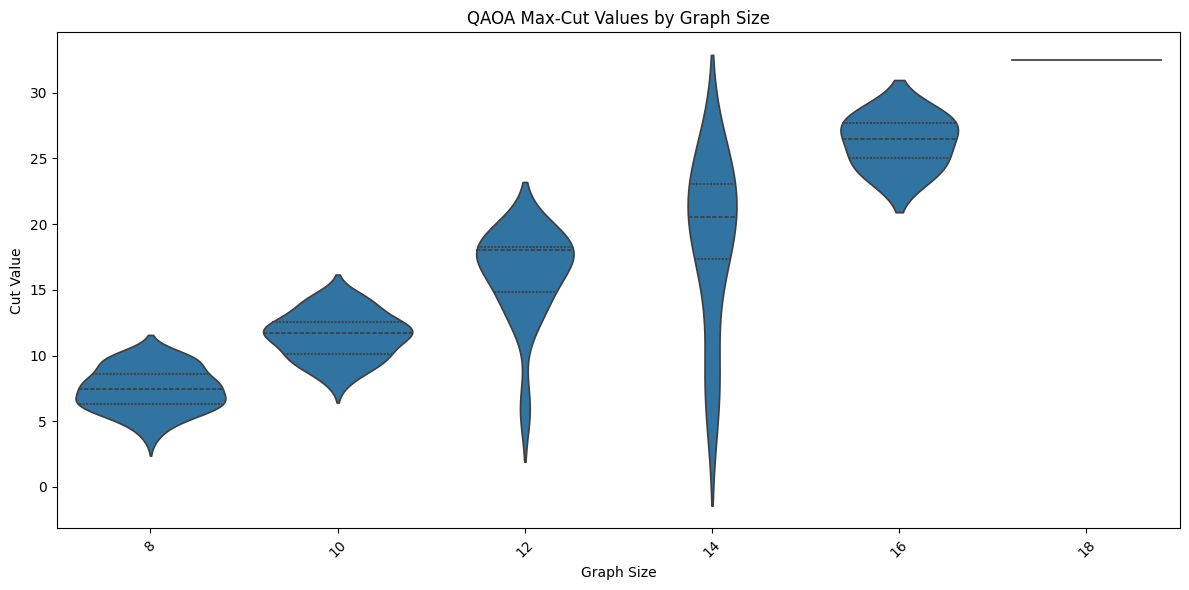

In [8]:
sizes = [8, 10, 12, 14, 16, 18]
edge_prob = 0.5
time_per_size = 600  # seconds
# 6 sizes with 600 seconds each = 1 hour total
p_layers = 3
optimizer_steps = 200

cut_values = run_qaoa_experiment_time_budget(
    [int(s) for s in sizes], 
    float(edge_prob), 
    int(time_per_size), 
    int(p_layers), 
    int(optimizer_steps)
)

df = pd.DataFrame({
    'Graph Size': np.repeat(sizes, [len(cut) for cut in cut_values]),
    'Cut Value': np.concatenate(cut_values)
})

# Save csv
os.makedirs('data/qaoa-data', exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
csv_path = f'data/qaoa-data/qaoa_{timestamp}.csv'
df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

# Save plot
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
plot_path = f'plots/qaoa-plots/qaoa_violin_{timestamp}.png'

plt.figure(figsize=(12, 6))
sns.violinplot(x='Graph Size', y='Cut Value', data=df, inner='quartile')
plt.title('QAOA Max-Cut Values by Graph Size')
plt.xlabel('Graph Size')
plt.ylabel('Cut Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")
plt.show()